# 時系列データの回帰分析方法について

参考　https://logics-of-blue.com/time-series-regression/  
重要。かなり良いこと書いてる。時系列データに対して、何も考えずに普通の(重)回帰分析を行うとまずいよっていう内容。時系列データには時系列分析の手順を踏む。

# 単位根過程 (和分過程)
単位根をもつデータを「単位根過程」と呼びます。  
単位根過程は別名「1次和分過程」とも言われます。  

和分とは、文字通り「足し合わせる」という意味ですね。  
なので、単位根とは「値が足しあわされて出来上がったデータである」と言えます。  

単位根過程の代表として挙げられるのが「ランダムウォーク」です。  
ランダムウォークはホワイトノイズの累積和として定義されます。  
ホワイトノイズは、自己相関も何もない、正規分布に従った、ただの「ノイズ」です。  

このようなノイズの累積和のことを単位根と呼びます。  

※単位根の正確な定義は「原系列が非定常過程であり、差分系列が定常過程となる系列のこと」を指しますが、ここでは話の単純化のため、ランダムウォークに絞って解説しています。  

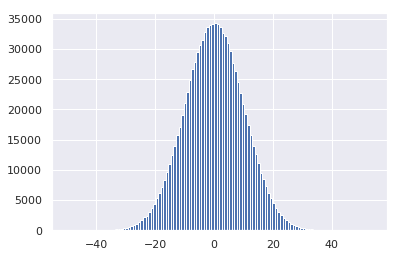

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
 
# 平均 0, 標準偏差 10 の正規乱数を1,000,000件生成
x = np.random.normal(0, 10, 1000000)
 
# ヒストグラムを出力
histogram = plt.hist(x, bins=120)

In [2]:
ex = np.array([1, 2, 3, 4, 5])
np.cumsum(ex)

array([ 1,  3,  6, 10, 15])

In [3]:
np.diff(ex, n=1)

array([1, 1, 1, 1])

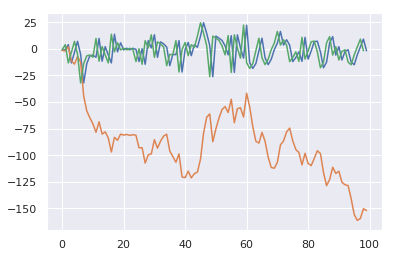

In [26]:
# 青：ホワイトノイズ、黄：ランダムウォーク(ノイズの和分過程)、緑：ランダムウォークの差分系列(元のノイズ)
noise = np.random.normal(0, 10, 100)
pd.Series(noise).plot()

walk = np.cumsum(noise)
pd.Series(walk).plot()

diff = np.diff(walk, n=1)
pd.Series(diff).plot()

# 単位根検定（ADF検定）
帰無仮説H0 : 時系列は単位根を含む  
対立仮設H1 : 時系列は弱定常過程  
P-value(有意確率)が0.05(有意水準)より小さければ帰無仮説H0は棄却され、対立仮説H1を採択する。

有意水準は一般的に5%が用いられる。さらに厳しい場合だと1%が用いられることも。

In [27]:
from arch.unitroot import ADF

In [28]:
ADF(noise)

Test Statistic,-9.488
P-value,0.000
Lags,0


In [29]:
ADF(walk)

Test Statistic,-2.069
P-value,0.257
Lags,0


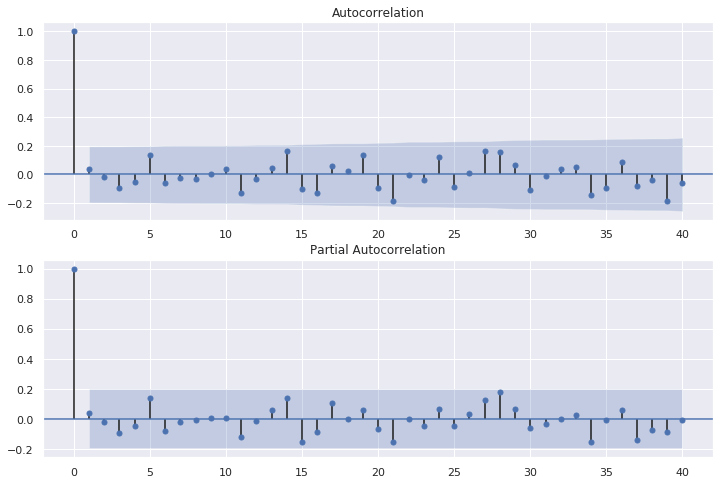

In [31]:
# 統計モデル
import statsmodels.api as sm

#  自己相関のグラフ
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(noise, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(noise, lags=40, method='ywmle', ax=ax2)

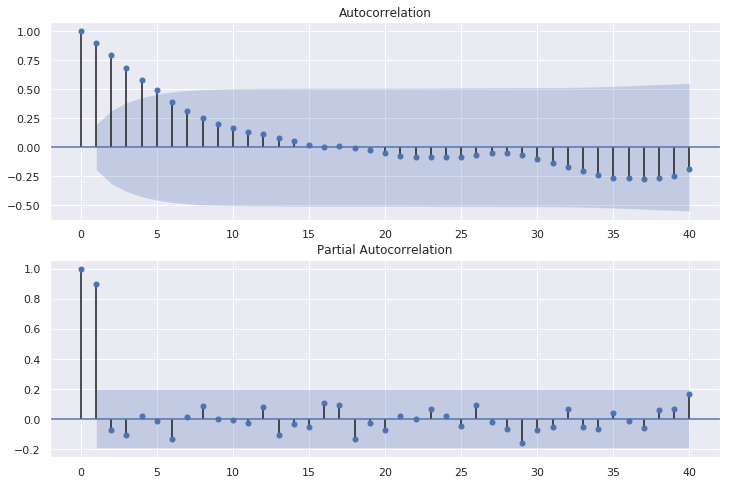

In [32]:
#  自己相関のグラフ
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(walk, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(walk, lags=40, method='ywmle', ax=ax2)

# 単位根がない場合、モデルの診断
https://www1.doshisha.ac.jp/~mjin/R/Chap_34/34.html

作成したモデルの適切さを判断するためには、残差分析が必要である。ARモデルにおける残差は平均0の正規分布に従い、残差の間には相関がないことを期待する。
　 Rには、時系列データの独立性を検定する関数 Box.test がある。関数 Box.test は、Box-Pierce 検定と Ljung-Box 検定を行う。この関数を用いて残差の独立性を検定することが可能である。
　 次に AR(3) モデルの残差の Ljung-Box 検定の例を示す。結果から分かるように、残差が独立である仮説が採択される。

# ノイズとランダムウォークをARIMAでモデリング
https://logics-of-blue.com/%E6%99%82%E7%B3%BB%E5%88%97%E8%A7%A3%E6%9E%90_%E3%83%9B%E3%83%AF%E3%82%A4%E3%83%88%E3%83%8E%E3%82%A4%E3%82%BA%E3%81%A8%E3%83%A9%E3%83%B3%E3%83%80%E3%83%A0%E3%82%A6%E3%82%A9%E3%83%BC%E3%82%AF  

1．モデルによる予測ができない時：ホワイトノイズ  
これからARIMAモデルを推定していくわけですが、そもそも自己相関が全くない、すなわち過去から未来を予測できないデータをお目にかけます。
自己相関の無い完全な雑音のようなデータのことをホワイトノイズと言います。
このホワイトノイズをforecastパッケージのauto.arimaでモデリングしてみましょう。

2．モデルによる予測ができない時：ランダムウォーク  
自己相関があっても単位根を持っているので未来は予測できない。（↔　RA,MAモデル）